## **演示0801：双类别逻辑回归**

### **提出问题**

假设某班学生的两门考试成绩(exam1 score, exam2 score)与最终评价是否合格(passed)的数据如下(部分数据)：  
![](../images/080101.png)  
根据上面的训练数据，如果再提供一组新的分数(例如：65, 58)，则该学生是否通过呢？

### **分析问题**
查看数据图像：

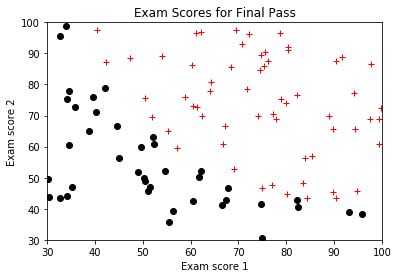

In [7]:
''' 查看成绩数据点的分布图 '''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def initPlot():
    plt.figure()
    plt.title('Exam Scores for Final Pass')
    plt.xlabel('Exam score 1')
    plt.ylabel('Exam score 2')
    plt.axis([30, 100, 30, 100])
    return plt

trainData = np.loadtxt(open('exam_score.csv', 'r'), delimiter=",",skiprows=1)

plt = initPlot()
score1ForPassed = trainData[trainData[:, 2] == 1, 0]    # 从trainData中获取下标索引第2列(passed)值为1的所有行的第0列元素
score2ForPassed = trainData[trainData[:, 2] == 1, 1]
score1ForUnpassed = trainData[trainData[:, 2] == 0, 0]
score2ForUnpassed = trainData[trainData[:, 2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')
plt.show()

水平方向为Exam 1 Score，垂直方向为Exam 2 Score。  
红色+点表示Passed=1，黑色圆圈点表示Passed=0。  
可以观察到，所有数据点较为明显的分成两个类别(通过或不通过)。   
线性回归主要都是针对训练数据和计算结果均为数值的情形。而在本例中，结果不是数值而是某种分类：考试成绩通过或不通过。在这种情况下，可以将每个类别作为一个数值结果，然后通过模型计算自变量与该分类数值结果之间的关系。逻辑回归则提供了这类问题的解决办法。

### **案例1：使用LogisticRegression**
>  
* 设置逻辑回归算法的某些属性  
<code>model = LogisticRegression(solver='lbfgs')</code>  
使用lbfgs算法来执行回归计算。默认使用liblinear。注意，这两种算法的结果并不相同  
* 执行计算  
<code>model.fit(X, y)</code>  
* 执行预测  
<code>model.predict(newX)</code>  
返回值是newX矩阵中每行数据所对应的结果。如果是1，则表示passed；如果是0，则表示unpassed
* 获得模型参数值  
<code>theta0 = model.intercept_[0]  
theta1 = model.coef_[0,0]  
theta2 = model.coef_[0,1]</code>
* 决策边界线
 * 决策边界线可视为两种类别数据点的分界线。在该分界线的一侧，所有数据点都被归为passed类(1)，另一侧的所有数据点都被归为unpassed类(0)
 * 对于本例来说，决策边界线是一条直线(在案例2中进行了说明)
 * *theta0*，*theta1*和*theta2*定义了决策边界线直线：$ \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 = 0 $  
 其中，$x_1$表示横坐标(Exam Score 1)，$x_2$表示纵坐标(Exam Score 2)，$x_0$表示该直线的截距

预测结果：
[1. 1. 0. 0.]


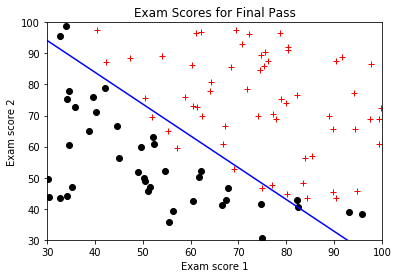

In [8]:
''' 使用LogisticRegression进行逻辑回归 '''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

trainData = np.loadtxt(open('exam_score.csv', 'r'), delimiter=",",skiprows=1)
xTrain = trainData[:,[0,1]]          # 无需追加Intercept Item列
yTrain = trainData[:,2]

model = LogisticRegression(solver='lbfgs')   # 使用lbfgs算法。默认是liblinear算法
model.fit(xTrain, yTrain)
newScores = np.array([[58, 67],[90, 90],[35, 38],[55, 56]])
print("预测结果：")
print(model.predict(newScores))
# 获取theta计算结果
theta = np.array([model.intercept_[0], model.coef_[0,0], model.coef_[0,1]])

def initPlot():
    plt.figure()
    plt.title('Exam Scores for Final Pass')
    plt.xlabel('Exam score 1')
    plt.ylabel('Exam score 2')
    plt.axis([30, 100, 30, 100])
    return plt

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')
boundaryX = np.array([30, 50, 70, 90, 100])                 # 绘制决策边界线
boundaryY = -(theta[1] * boundaryX + theta[0]) / theta[2]   # 根据决策边界线的直线公式和x值，计算对应的y值
plt.plot(boundaryX, boundaryY, 'b-')
plt.show()

上图做出了决策边界线，该线左下方的数据点，被认为分到第0类(考试不通过)，该线右上方的数据点，被认为分到第1类(考试通过)  
决策边界线不一定能正好把所有有本都正确的分类，除非采用更高阶的模型(而不是本例中的线性模型)。但是高阶模型也可能产生过拟合。

### **案例2：基于成本函数和梯度下降算法的实现**
>  
* 判别式/预测函数  
$ h_\theta(x)=g(x_0 \theta_0+ x_1 \theta_1+ \cdots + x_n \theta_n )=g(x * \theta) $  
 * $x$代表一个(行)样本数据，该样本数据共有$n$个变量(维度)
 * $x_0$为Intercept Item，一般设置为1
 * $g$称为sigmoid激活函数，其定义为：$g(z)= \dfrac{1}{1+e^{-z}} $，该函数图像如下：  
  ![](../images/080102.png)  
   * 可以看到，当$z=0$时，$g(z)$的值为0.5。低于0.5的$g(z)$可以认为预测为false，高于0.5的预测为true。
   * 激活函数相当于起了这样的作用：将一个连续的数值量，基于设定的阈值转变成离散的分类结果
* 成本函数：  
$ J(\theta)= \dfrac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta(x^{(i)})) -(1 - y^{(i)})log(1 - h_\theta(x^{(i)}))] $  
使用矩阵运算表达如下：  
$ J(\theta)=\dfrac{-y^T * log(g(X * \theta))-(1-y^T) * log(1-g(X * \theta))}{m} $  
* 梯度计算：  
$ \theta_j=\theta_j - \alpha(\dfrac{\partial J(\theta)}{\partial \theta_j}) $  
$ \dfrac{\partial J(\theta)}{\theta_j} = \dfrac{1}{m} \sum_{i=1}^m [(h_\theta (x^{(i)}) - y^{(i)}) x_j^{(i)}]=\dfrac{1}{m} (X^T * (g(X * \theta) - y)) $  
* 计算决策边界线(Decision Boundary)：
决策边界线上所有的点，其预测出来的$y$值（$h_\theta(x)$）正好为0.5，即：  
$ \dfrac{1}{1+e^{-z}}=0.5 => z = x * \theta = 0 $  
当$n=2$时有：$\theta_0+\theta_1 x_1+ \theta_2 x_2=0$ ，该边界线是一条直线
* 程序编写注意事项：
 * 仔细思考成本函数和梯度计算的矩阵运算实现
 * 先对数据进行归一化处理，有助于计算收敛
   * 训练数据和测试数据需要手动添加Intercept Item列。先进行归一化，再手动添加Intercept Item
   * 测试数据也需要进行相应的归一化处理，才能预测。
   * 绘制边界线时，边界线上的点横坐标数据也需要先归一处理，然后求出归一化的纵坐标，最后再回算出纵坐标的正常值
   * 一般情况下，测试数据、边界线数据在进行归一化处理时，都应该采用训练数据中计算出来的列平均值，而不是它们自身的平均值

循环 4091 次后收敛
预测结果：
[0.51633196 0.99561631 0.00693267 0.2188808 ]


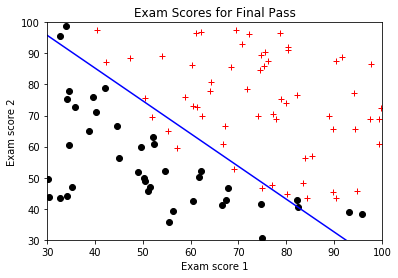

In [9]:
''' 使用梯度下降算法进行逻辑回归 '''

%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import bgd_resolver

def normalizeData(X, column_mean, column_std):
    return (X - column_mean) / column_std

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

def costFn(theta, X, y):
    temp = sigmoid(X.dot(theta))
    cost = -y.dot(np.log(temp)) - (1 - y).dot(np.log(1 - temp))
    return cost / len(X)

def gradientFn(theta, X, y):
    return xTrain.T.dot(sigmoid(xTrain.dot(theta)) - yTrain) / len(X)

def initPlot():
    plt.figure()
    plt.title('Exam Scores for Final Pass')
    plt.xlabel('Exam score 1')
    plt.ylabel('Exam score 2')
    plt.axis([30, 100, 30, 100])
    return plt


trainData = np.loadtxt(open('exam_score.csv', 'r'), delimiter=",",skiprows=1)
xTrain = trainData[:, [0, 1]]
# 计算训练数据每列平均值和每列的标准差
xTrain_column_mean = xTrain.mean(axis=0)
xTrain_column_std = xTrain.std(axis=0)
xTrain = normalizeData(xTrain, xTrain_column_mean, xTrain_column_std)      # 如果不进行归一化处理，计算过程中可能产生溢出(但似乎仍可以收敛)
x0 = np.ones(len(xTrain))
xTrain = np.c_[x0, xTrain]          # 需手动追加Intercept Item列
yTrain = trainData[:,2]

np.random.seed(0)
init_theta = np.random.random(3)    # 随机初始化theta
theta = bgd_resolver.batch_gradient_descent(costFn, gradientFn, init_theta, xTrain, yTrain, 0.005, 0.00001)

# 预测若干数据,也需要先归一化，使用之前训练数据的mean和std
newScores = np.array([[58, 67], [90, 90], [35, 38], [55, 56]]) 
newScores = normalizeData(newScores, xTrain_column_mean, xTrain_column_std)
x0 = np.ones(len(newScores))
newScores = np.c_[x0, newScores]  # 注意要添加Intercept Item
print("预测结果：")
print(sigmoid(newScores.dot(theta)))

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]	
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')

# 绘制决策边界线
boundaryX = np.array([30, 50, 70, 90, 100])
# 因为之前进行了归一化，因此边界线上点的x坐标也需要先归一化。x坐标对应的列索引是0
normalizedBoundaryX = (boundaryX - xTrain_column_mean[0]) / xTrain_column_std[0]
# 下面计算出来的边界线上的y坐标normalizedBoundaryY是经过归一化处理的坐标 
normalizedBoundaryY = -(theta[1] * normalizedBoundaryX + theta[0] ) / theta[2]
# boundaryY才是将归一化坐标还原成正常坐标。y坐标对应的列索引是1
boundaryY = xTrain_column_std[1] * normalizedBoundaryY + xTrain_column_mean[1]

plt.plot(boundaryX, boundaryY, 'b-')
plt.show()

### **案例3：基于scipy.optimize优化运算库的实现**
>  
* 使用minimize库函数
* 需要提供jac参数，并将其设置为梯度计算函数
* scipy.optimize库中提供的算法会比我们自己实现的算法更高效、灵活、全面
* 本例中没有对数据进行归一处理，因此导致minimize方法执行过程中溢出(尽管可能也能收敛)。请自行添加归一化处理功能

Optimization terminated successfully.
         Current function value: 0.203686
         Iterations: 26
         Function evaluations: 53
         Gradient evaluations: 53
预测结果：
[5.74299382e-01 9.99989986e-01 3.47786167e-05 7.37808680e-02]


c:\users\iahuo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
c:\users\iahuo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
c:\users\iahuo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
c:\users\iahuo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
c:\users\iahuo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


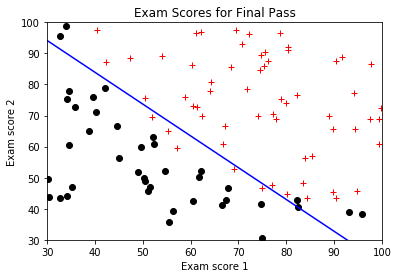

In [10]:
''' 使用minimize来优化逻辑回归求解 '''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# 定义全局变量
trainData = np.loadtxt(open('exam_score.csv', 'r'), delimiter=",",skiprows=1)
xTrain = trainData[:,[0, 1]]
x0 = np.ones(len(xTrain))
xTrain = np.c_[x0, xTrain]
yTrain = trainData[:,2]

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

# Cost Function以theta为参数
def costFn(theta, X, y):
    temp = sigmoid(xTrain.dot(theta))
    cost = -yTrain.dot(np.log(temp)) - (1 - yTrain).dot(np.log(1 - temp))
    return cost / len(X)

# Gradient Function以theta为参数
def gradientFn(theta, X, y):
    return xTrain.T.dot(sigmoid(xTrain.dot(theta)) - yTrain) / len(X)

np.random.seed(0)
# 随机初始化theta，计算过程中可能产生溢出。
# 可以尝试将init_theta乘以0.01，这样可以防止计算溢出
init_theta = np.random.random(xTrain.shape[1])      
result = opt.minimize(costFn, init_theta, args=(xTrain, yTrain), method='BFGS', jac=gradientFn, options={'disp': True})
theta = result.x            # 最小化Cost时的theta

# 预测若干数据
newScores = np.array([[1, 58, 67],[1, 90,90],[1, 35,38],[1, 55,56]])  # 注意要添加Intercept Item
print("预测结果：")
print(sigmoid(newScores.dot(theta)))

def initPlot():
    plt.figure()
    plt.title('Exam Scores for Final Pass')
    plt.xlabel('Exam score 1')
    plt.ylabel('Exam score 2')
    plt.axis([30, 100, 30, 100])
    return plt

plt = initPlot()
score1ForPassed = trainData[trainData[:,2] == 1, 0]	
score2ForPassed = trainData[trainData[:,2] == 1, 1]
score1ForUnpassed = trainData[trainData[:,2] == 0, 0]
score2ForUnpassed = trainData[trainData[:,2] == 0, 1]
plt.plot(score1ForPassed,score2ForPassed,'r+')
plt.plot(score1ForUnpassed,score2ForUnpassed,'ko')
boundaryX = np.array([30, 50, 70, 90, 100])                     # 绘制决策边界线
boundaryY = -(theta[1] * boundaryX + theta[0]) / theta[2]
plt.plot(boundaryX,boundaryY, 'b-')
plt.show()